In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Keras with tensorflow backend
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications import VGG16

# Import OpenCV
import cv2

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# Confusion Matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report

# Plot
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Set dataset folder path
BASE_DATASET_FOLDER = '/content/drive/MyDrive/new data final'
TRAIN_FOLDER = "/content/drive/MyDrive/new data final/train"
VALIDATION_FOLDER = "/content/drive/MyDrive/new data final/validation"
TEST_FOLDER = '/content/drive/MyDrive/new data final/test'

# ResNet50 image size
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# Keras settings
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.0001
#MODEL_PATH = os.path.join("new_model_training.h5")

In [ ]:
def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=TRAIN_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=True)

Found 1319 images belonging to 5 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),
        target_size=IMAGE_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 159 images belonging to 5 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=VAL_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 167 images belonging to 5 classes.


In [ ]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'Doubtful', 1: 'Mild', 2: 'Moderate', 3: 'Normal', 4: 'Severe'}


In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

In [ ]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples//val_generator.batch_size)

Epoch 1/50
20/20 [==============================] - 275s 13s/step - loss: 1.5990 - acc: 0.3028 - val_loss: 1.4780 - val_acc: 0.3438
Epoch 2/50
20/20 [==============================] - 23s 1s/step - loss: 1.4596 - acc: 0.3514 - val_loss: 1.5432 - val_acc: 0.2891
Epoch 3/50
20/20 [==============================] - 23s 1s/step - loss: 1.3456 - acc: 0.4008 - val_loss: 1.5018 - val_acc: 0.3203
Epoch 4/50
20/20 [==============================] - 24s 1s/step - loss: 1.2255 - acc: 0.4829 - val_loss: 1.4396 - val_acc: 0.3438
Epoch 5/50
20/20 [==============================] - 22s 1s/step - loss: 1.1939 - acc: 0.4988 - val_loss: 1.3772 - val_acc: 0.3672
Epoch 6/50
20/20 [==============================] - 23s 1s/step - loss: 1.1708 - acc: 0.5044 - val_loss: 1.5944 - val_acc: 0.3828
Epoch 7/50
20/20 [==============================] - 23s 1s/step - loss: 1.0412 - acc: 0.5713 - val_loss: 1.6051 - val_acc: 0.3594
Epoch 8/50
20/20 [==============================] - 23s 1s/step - loss: 0.9450 - acc: 0.

In [ ]:
model.save('model.h5')

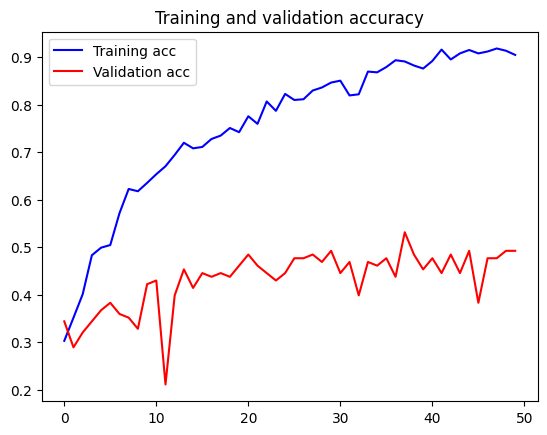

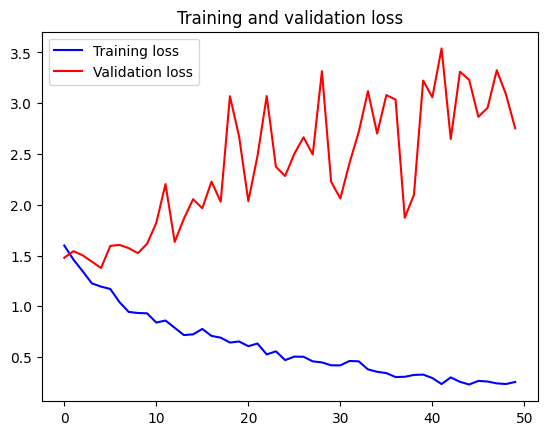

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
%%time
loss, accuracy = model.evaluate_generator(test_generator,steps=test_generator.samples//test_generator.batch_size)

CPU times: user 2.21 s, sys: 134 ms, total: 2.34 s
Wall time: 34.6 s


In [ ]:
print("Accuracy: %f\nLoss: %f" % (accuracy,loss))


Accuracy: 0.787500
Loss: 0.817448


In [ ]:
%%time
Y_pred = model.predict_generator(test_generator,verbose=1, steps=test_generator.samples//test_generator.batch_size)

20/20 [==============================] - 1s 48ms/step
CPU times: user 1.57 s, sys: 65.2 ms, total: 1.63 s
Wall time: 1.41 s


In [ ]:
y_pred = np.argmax(Y_pred, axis=1)


In [ ]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [ ]:
y_pred

array([3, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 3, 0, 0, 3, 3, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0,
       3, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 3, 3, 3,
       0, 0, 1, 0, 0, 0, 0, 3, 0, 3, 1, 1, 3, 3, 0, 3, 0, 0, 0, 1, 0, 2,
       1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1,
       0, 0, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 4, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 3, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [ ]:
def load_image(filename):
    img = cv2.imread(os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Moderate, file: Moderate/ModerateG3 (144).png
1/1 [==============================] - 2s 2s/step
PREDICTED: class: Moderate, confidence: 0.999659


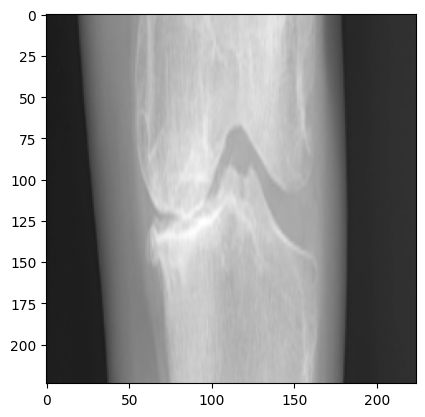

<Figure size 640x480 with 0 Axes>

SOURCE: class: Moderate, file: Moderate/ModerateG3 (176).png
1/1 [==============================] - 0s 195ms/step
PREDICTED: class: Mild, confidence: 0.521640


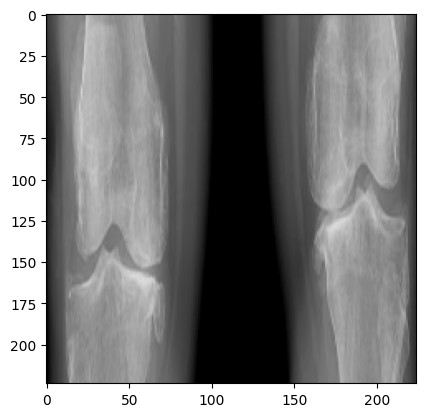

SOURCE: class: Normal, file: Normal/NormalG0 (347).png
1/1 [==============================] - 0s 102ms/step
PREDICTED: class: Normal, confidence: 0.993959


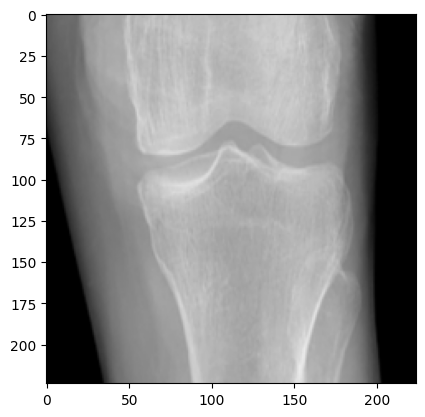

<Figure size 640x480 with 0 Axes>

SOURCE: class: Mild, file: Mild/MildG2 (153).png
1/1 [==============================] - 0s 40ms/step
PREDICTED: class: Moderate, confidence: 0.998067


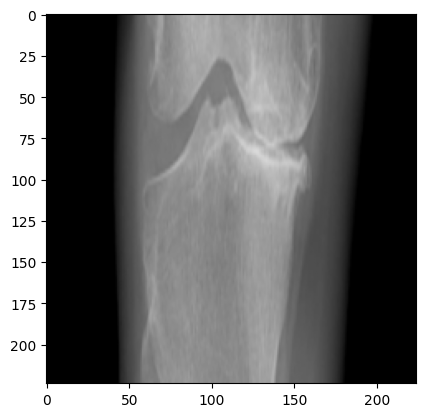

<Figure size 640x480 with 0 Axes>

SOURCE: class: Normal, file: Normal/NormalG0 (397).png
1/1 [==============================] - 0s 30ms/step
PREDICTED: class: Normal, confidence: 0.998767


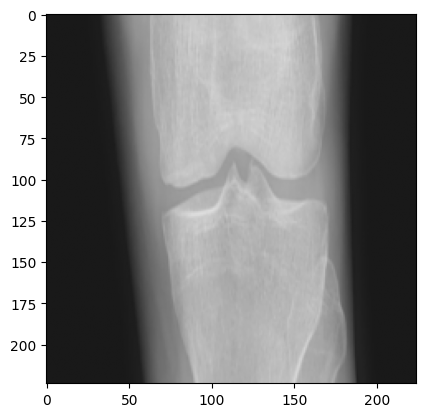

<Figure size 640x480 with 0 Axes>

SOURCE: class: Severe, file: Severe/SevereG4 (150).png
1/1 [==============================] - 0s 87ms/step
PREDICTED: class: Severe, confidence: 0.993986


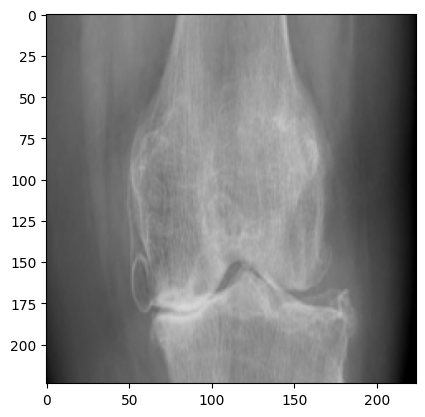

<Figure size 640x480 with 0 Axes>

SOURCE: class: Normal, file: Normal/NormalG0 (408).png
1/1 [==============================] - 0s 55ms/step
PREDICTED: class: Doubtful, confidence: 0.999895


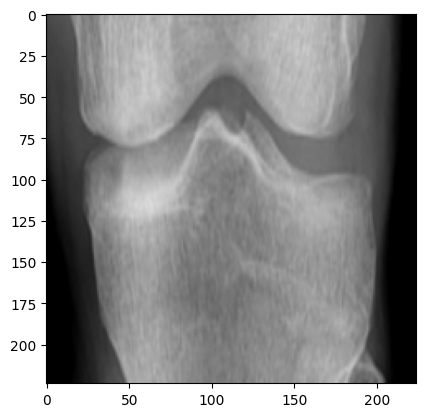

<Figure size 640x480 with 0 Axes>

SOURCE: class: Severe, file: Severe/SevereG4 (165).png
1/1 [==============================] - 0s 41ms/step
PREDICTED: class: Severe, confidence: 0.751612


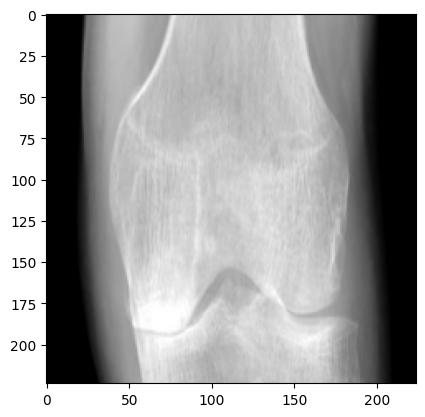

<Figure size 640x480 with 0 Axes>

SOURCE: class: Severe, file: Severe/SevereG4 (155).png
1/1 [==============================] - 0s 49ms/step
PREDICTED: class: Severe, confidence: 0.981968


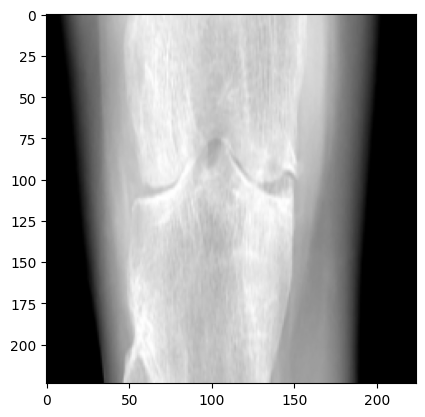

<Figure size 640x480 with 0 Axes>

SOURCE: class: Normal, file: Normal/NormalG0 (381).png
1/1 [==============================] - 0s 49ms/step
PREDICTED: class: Normal, confidence: 0.998421


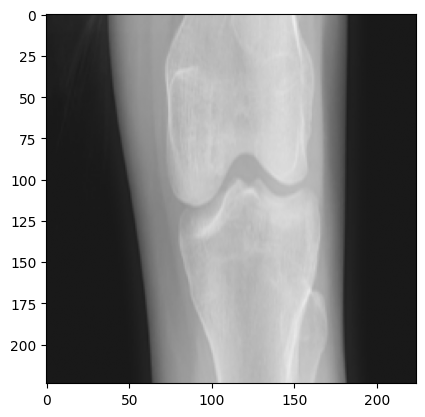

<Figure size 640x480 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score

doubtful_dir = "/content/drive/MyDrive/new data final/test/Doubtful/" # Définir le chemin du dossier "Doubtful"
true_labels = []
predicted_labels = []

for filename in os.listdir(doubtful_dir):
    if not os.path.isfile(os.path.join(doubtful_dir, filename)):
        continue # Ignorer les dossiers
    
    true_label = os.path.basename(os.path.dirname(os.path.join(doubtful_dir, filename))) # Récupérer le nom du dossier parent comme étiquette réelle
    img = load_image(os.path.join(doubtful_dir, filename))
    prediction = predict(img)
    predicted_label = list(prediction.keys())[0] # Utiliser la prédiction la plus probable comme étiquette prédite
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

average_precision = accuracy_score(true_labels, predicted_labels) # Calculer la précision moyenne
print("Average precision:", average_precision)

1/1 [==============================] - 0s 24ms/step
Average precision: 0.5652173913043478


In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score

doubtful_dir = "/content/drive/MyDrive/new data final/test/Normal/" # Définir le chemin du dossier "Doubtful"
true_labels = []
predicted_labels = []

for filename in os.listdir(doubtful_dir):
    if not os.path.isfile(os.path.join(doubtful_dir, filename)):
        continue # Ignorer les dossiers
    
    true_label = os.path.basename(os.path.dirname(os.path.join(doubtful_dir, filename))) # Récupérer le nom du dossier parent comme étiquette réelle
    img = load_image(os.path.join(doubtful_dir, filename))
    prediction = predict(img)
    predicted_label = list(prediction.keys())[0] # Utiliser la prédiction la plus probable comme étiquette prédite
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

average_precision = accuracy_score(true_labels, predicted_labels) # Calculer la précision moyenne
print("Average precision:", average_precision)

1/1 [==============================] - 0s 21ms/step
Average precision: 0.9411764705882353


In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score

doubtful_dir = "/content/drive/MyDrive/new data final/test/Mild/" # Définir le chemin du dossier "Doubtful"
true_labels = []
predicted_labels = []

for filename in os.listdir(doubtful_dir):
    if not os.path.isfile(os.path.join(doubtful_dir, filename)):
        continue # Ignorer les dossiers
    
    true_label = os.path.basename(os.path.dirname(os.path.join(doubtful_dir, filename))) # Récupérer le nom du dossier parent comme étiquette réelle
    img = load_image(os.path.join(doubtful_dir, filename))
    prediction = predict(img)
    predicted_label = list(prediction.keys())[0] # Utiliser la prédiction la plus probable comme étiquette prédite
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

average_precision = accuracy_score(true_labels, predicted_labels) # Calculer la précision moyenne
print("Average precision:", average_precision)

1/1 [==============================] - 0s 24ms/step
Average precision: 0.6


In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score

doubtful_dir = "/content/drive/MyDrive/new data final/test/Moderate/" # Définir le chemin du dossier "Doubtful"
true_labels = []
predicted_labels = []

for filename in os.listdir(doubtful_dir):
    if not os.path.isfile(os.path.join(doubtful_dir, filename)):
        continue # Ignorer les dossiers
    
    true_label = os.path.basename(os.path.dirname(os.path.join(doubtful_dir, filename))) # Récupérer le nom du dossier parent comme étiquette réelle
    img = load_image(os.path.join(doubtful_dir, filename))
    prediction = predict(img)
    predicted_label = list(prediction.keys())[0] # Utiliser la prédiction la plus probable comme étiquette prédite
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

average_precision = accuracy_score(true_labels, predicted_labels) # Calculer la précision moyenne
print("Average precision:", average_precision)

1/1 [==============================] - 0s 18ms/step
Average precision: 0.9166666666666666


In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score

doubtful_dir = "/content/drive/MyDrive/new data final/test/Severe/" # Définir le chemin du dossier "Doubtful"
true_labels = []
predicted_labels = []

for filename in os.listdir(doubtful_dir):
    if not os.path.isfile(os.path.join(doubtful_dir, filename)):
        continue # Ignorer les dossiers
    
    true_label = os.path.basename(os.path.dirname(os.path.join(doubtful_dir, filename))) # Récupérer le nom du dossier parent comme étiquette réelle
    img = load_image(os.path.join(doubtful_dir, filename))
    prediction = predict(img)
    predicted_label = list(prediction.keys())[0] # Utiliser la prédiction la plus probable comme étiquette prédite
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

average_precision = accuracy_score(true_labels, predicted_labels) # Calculer la précision moyenne
print("Average precision:", average_precision)

1/1 [==============================] - 0s 21ms/step
Average precision: 0.5714285714285714
